### Basic importing of modules, clever loop for importing all raw data frames efficiently

In [1]:
import glob
import os
import pandas as pd

folder_paths = ["Controls", "LC", "ME"]

# Dictionaries to hold DataFrames and headers for each folder
all_dfs = {}
all_headers = {}

for path in folder_paths:
    csv_files = glob.glob(os.path.join(path, '*.xlsx'))
    print(csv_files)
    # Read data without headers, skipping the first 3 rows
    dfs = [pd.read_excel(file, header=None, skiprows=3) for file in csv_files]
    
    # Read the header row separately (the row just before the data starts, so skiprows=2)
    headers = [pd.read_excel(file, nrows=1, header=None) for file in csv_files]
    
    # Assign the header row to each DataFrame
    for df, header in zip(dfs, headers):
        df.columns = header.iloc[0]
        
    # Store the DataFrames and headers in the dictionaries
    all_dfs[path] = dfs
    all_headers[path] = headers

# 25 seconds

['Controls\\P110061.xlsx', 'Controls\\P110090.xlsx', 'Controls\\P110096.xlsx', 'Controls\\P110097.xlsx', 'Controls\\P110098.xlsx', 'Controls\\P110099.xlsx', 'Controls\\P110101.xlsx', 'Controls\\P110102.xlsx', 'Controls\\P110103.xlsx', 'Controls\\P110104.xlsx', 'Controls\\P110106.xlsx', 'Controls\\P110107.xlsx', 'Controls\\P110109.xlsx', 'Controls\\P110110.xlsx', 'Controls\\P110112.xlsx', 'Controls\\P110114.xlsx', 'Controls\\P110115.xlsx', 'Controls\\P110126_P110126_CPET.xlsx', 'Controls\\P110132_P110132_CPET.xlsx', 'Controls\\P110139_P110139_CPET.xlsx', 'Controls\\P110140_110140_CPET.xlsx', 'Controls\\P110148_P110148_CPET.xlsx', 'Controls\\P110149_P110149_CPET.xlsx', 'Controls\\P110150_P110150_CPET.xlsx', 'Controls\\P110151_P110151_CPET.xlsx', 'Controls\\P110152_P110152_CPET.xlsx']
['LC\\P110017.xlsx', 'LC\\P110039.xlsx', 'LC\\P110050.xlsx', 'LC\\P110051.xlsx', 'LC\\P110055.xlsx', 'LC\\P110056.xlsx', 'LC\\P110058.xlsx', 'LC\\P110064.xlsx', 'LC\\P110085.xlsx', 'LC\\P110086.xlsx', 'LC\\P

### Create a copy of the grouped data frame to work with, to avoid having to import all the data frames over and over again

In [2]:
all_dfs_c = {'Controls':[], 'LC':[], 'ME':[]}
groups = ['Controls', 'LC', 'ME']
for group in groups:
    group_list = []
    for df in all_dfs[group]:
        group_list.append(df.copy())
    all_dfs_c[group] = group_list

### Count the amount of dataframes with missing columns_to_keep, and identify missing columns

In [23]:
cols_to_use = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Phase']
count = {col: 0 for col in cols_to_use}
no_count = {col: 0 for col in cols_to_use}
for group_name, group in all_dfs_c.items():
    for df in group:
        for col in cols_to_use:
            if col in df.columns:
                count[col] += 1
            else:
                no_count[col] += 1
print(count)
print(no_count)
for i in no_count:
    if no_count[i] > 0:
        print(i)
        print(no_count[i])

{'t': 63, 'Power': 63, 'HR': 60, 'VE': 63, 'VO2': 63, 'VCO2': 63, 'PetCO2': 63, 'PetO2': 63, 'VO2/Kg': 63, 'VE/VO2': 63, 'VE/VCO2': 63, 'RQ': 63, 'VT': 63, 'Rf': 63, 'Ti': 63, 'Te': 63, 'Phase': 63}
{'t': 0, 'Power': 0, 'HR': 3, 'VE': 0, 'VO2': 0, 'VCO2': 0, 'PetCO2': 0, 'PetO2': 0, 'VO2/Kg': 0, 'VE/VO2': 0, 'VE/VCO2': 0, 'RQ': 0, 'VT': 0, 'Rf': 0, 'Ti': 0, 'Te': 0, 'Phase': 0}
HR
3


### Remove unwanted columns, and subsequently removing NaN's   


In [24]:
for group_name, group in all_dfs_c.items():
    for df in group:
        col_rem_2b = [col for col in df.columns if col not in cols_to_use]
        df.drop(columns = col_rem_2b, inplace = True)

for group_name, group in all_dfs_c.items():
    for df in group:
        df.dropna(inplace=True)
Control = all_dfs_c['Controls']
LC = all_dfs_c['LC']
ME = all_dfs_c['ME']

for groupname, group in all_dfs_c.items():
    for i,df in enumerate(group):
        df['Participant'] = f'{groupname}_{i}'

### Concat all dataframes of a single participant group, and change the column order

In [25]:
Control_df = pd.concat((Control), axis = 0)
LC_df = pd.concat((LC), axis = 0)
ME_df = pd.concat((ME), axis = 0)

col_order = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Participant', 'Phase']
Control_df = Control_df[col_order]
LC_df = LC_df[col_order]
ME_df = ME_df[col_order]

CHANGING DATE STRING TO SECONDS

In [26]:
def hhmmss_to_seconds(hhmmss):
    h, m, s = map(int, hhmmss.split(':'))
    return h * 3600 + m * 60 + s

for df in [Control_df, LC_df, ME_df]:
    df['t'] = df['t'].astype('string')
    df['t'] = df['t'].apply(hhmmss_to_seconds)


### Remove rows where the participant is not exercising (See paper for more information)

In [27]:
import copy
Control_df_edit = copy.deepcopy(Control_df)
ME_df_edit = copy.deepcopy(ME_df)
edit_c = dict(zip(['Controls_' + str(i) for i in range(21,26)], [190, 388, 331, 412, 290]))

edit_ME = dict(zip(['ME_' + str(i) for i in range(22,26)], [318, 332, 350, 238]))
Control_df_edit.reset_index(inplace = True)
ME_df_edit.reset_index(inplace = True)
for edit, df in zip([edit_c, edit_ME], [Control_df_edit, ME_df_edit]):
    to_drop = []
    for participant in edit.keys():
        start_exercise = df.groupby('Participant').head(1).index.tolist()[int(participant[-2:])]
        end_exercise = start_exercise + edit[participant]
        end_trial = df.groupby('Participant').tail(1).index.tolist()[int(participant[-2:])]
        to_drop += list(df.index[end_exercise:end_trial+1])
    df.drop(to_drop, inplace = True)
    df.set_index('index', inplace = True)

##### Fixing Control Data

Text(0.5, 1.0, 'Expiratory Time (Te) after correction')

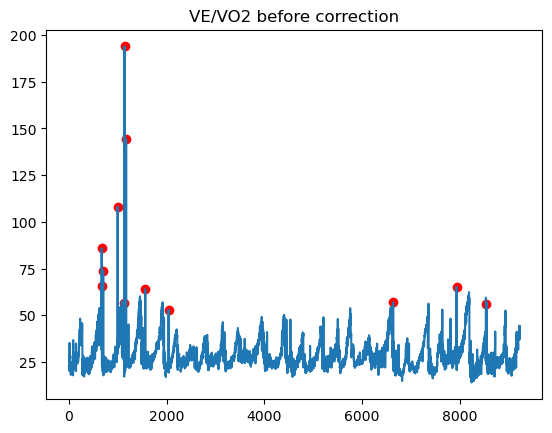

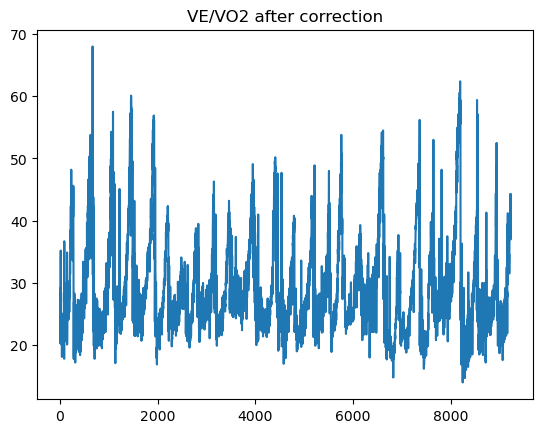

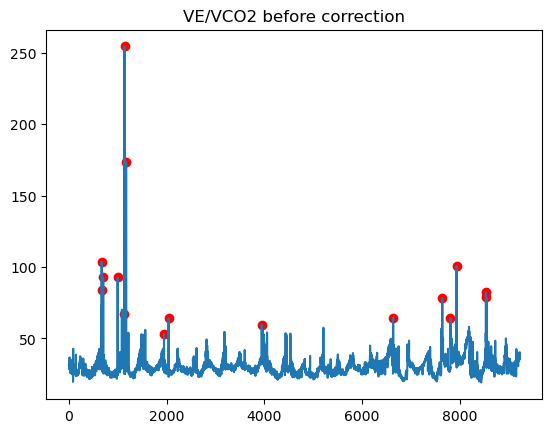

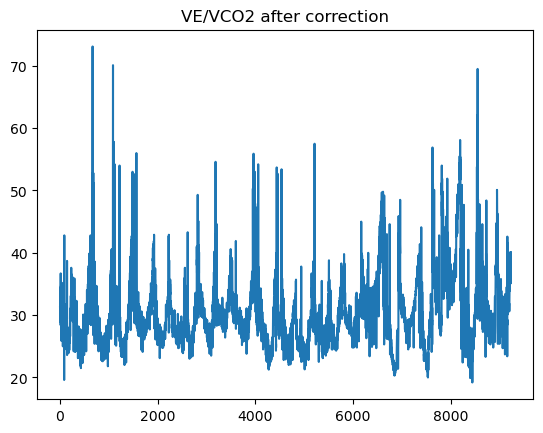

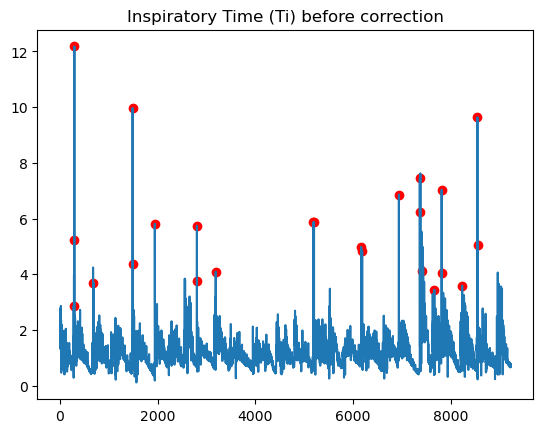

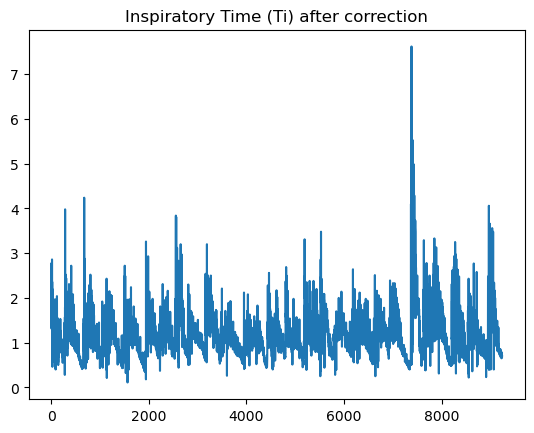

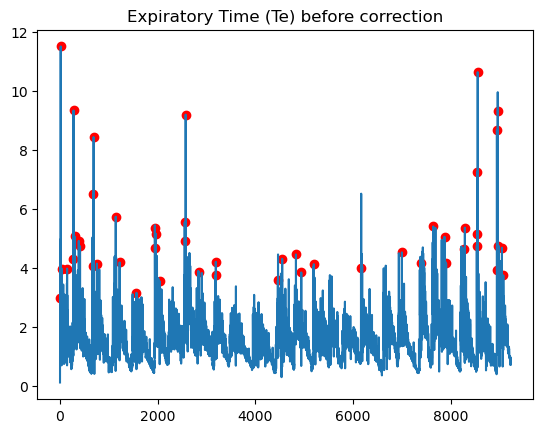

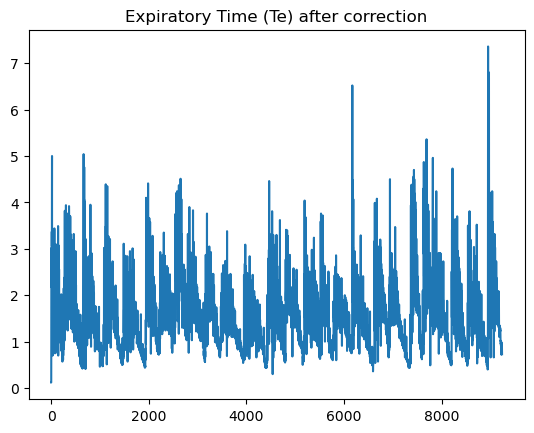

In [28]:
Control_df_edit.reset_index(inplace = True)
Control_df_edit.drop(columns = 'index', inplace = True)
import numpy as np
import matplotlib.pyplot as plt

# Fix HR 
Control_df_edit.loc[666:678, 'HR'] = Control_df_edit.loc[666:678, 'HR'].apply(lambda x: 84 if x < 50 else x)
HR299 = Control_df_edit[Control_df_edit['HR'] < 50].index
if HR299.size > 0:
    Control_df_edit.loc[HR299[0], 'HR'] = np.mean([Control_df_edit['HR'][HR299[0]+1],Control_df_edit['HR'][HR299[0]-1]])

# Fix VE/VO2
def find_large_increments(list, increment):
    result = []
    for i in range(1, len(list)):
        if list[i] - list[i-1] > increment:
            result.append(i)
    return result
vevo2_incr = find_large_increments(Control_df_edit['VE/VO2'], 25)
plt.plot(Control_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, Control_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    Control_df_edit.loc[i, 'VE/VO2'] = Control_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(Control_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

# Fix VE/VCO2
plt.figure()
vevco2_incr = find_large_increments(Control_df_edit['VE/VCO2'], 25)
plt.plot(Control_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, Control_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    Control_df_edit.loc[i, 'VE/VCO2'] = Control_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(Control_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

# Fix Ti
plt.figure()
plt.plot(Control_df_edit['Ti'])
ti_incr = find_large_increments(Control_df_edit['Ti'], 2.5)
plt.scatter(ti_incr, Control_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    Control_df_edit.loc[i, 'Ti'] = Control_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(Control_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

# Fix Te
te_incr = find_large_increments(Control_df_edit['Te'], 2.5)
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.scatter(te_incr, Control_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
te_incr = find_large_increments(Control_df_edit['Te'], 4)
for i in te_incr:
    Control_df_edit.loc[i, 'Te'] = Control_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(Control_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

##### Fixing ME data
    

Series([], Name: HR, dtype: float64)
212    0.0
213    0.0
214    0.0
215    0.0
216    0.0
      ... 
342    0.0
343    0.0
344    0.0
345    0.0
346    0.0
Name: HR, Length: 135, dtype: float64
Series([], Name: HR, dtype: float64)
466    0.0
467    0.0
468    0.0
469    0.0
Name: HR, dtype: float64
787      0.0
788      0.0
789      0.0
790      0.0
791      0.0
        ... 
1156    68.0
1157    68.0
1158    68.0
1159    68.0
1160    68.0
Name: HR, Length: 347, dtype: float64
Series([], Name: HR, dtype: float64)
Series([], Name: HR, dtype: float64)
1819    0.0
1820    0.0
1821    0.0
1822    0.0
1823    0.0
       ... 
2066    0.0
2067    0.0
2068    0.0
2069    0.0
2077    0.0
Name: HR, Length: 192, dtype: float64
Series([], Name: HR, dtype: float64)
2392    60.0
2393    60.0
2394    61.0
2395    61.0
2396    61.0
        ... 
2467    69.0
2468    69.0
2469    69.0
2470    68.0
2471    69.0
Name: HR, Length: 63, dtype: float64
Series([], Name: HR, dtype: float64)
Series([], Name: HR

Text(0.5, 1.0, 'Expiratory Time (Te) after correction')

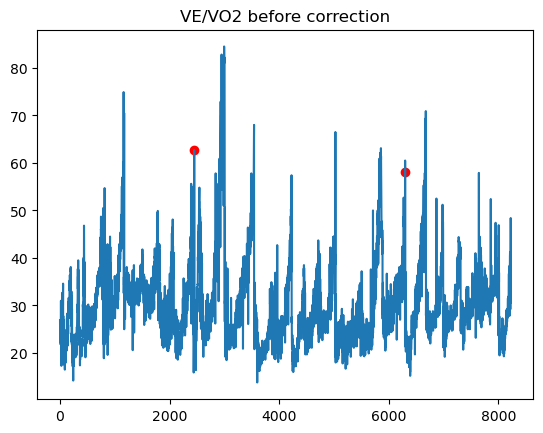

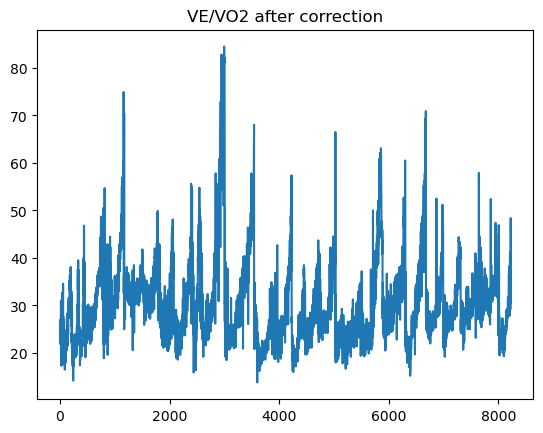

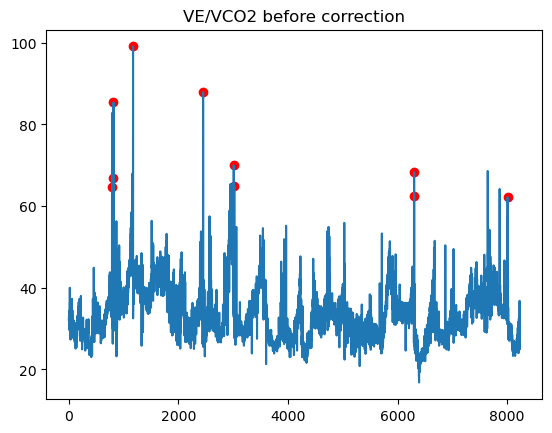

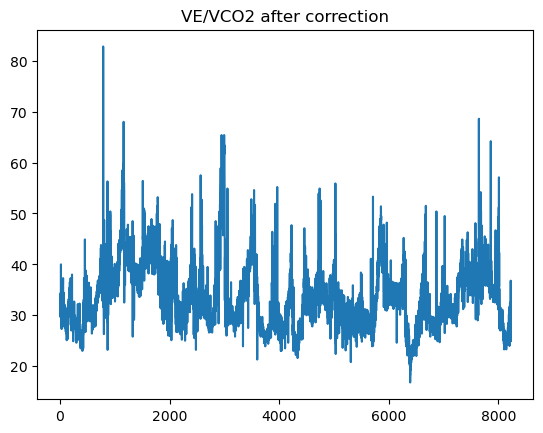

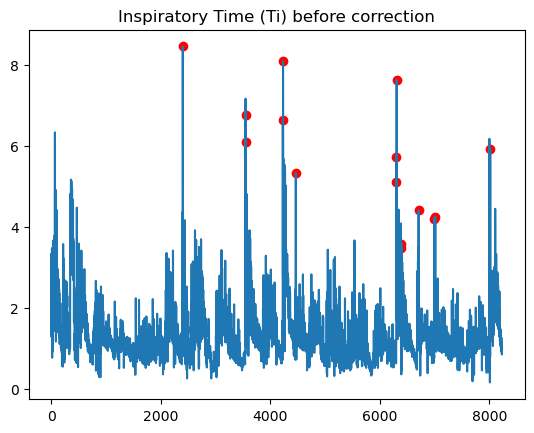

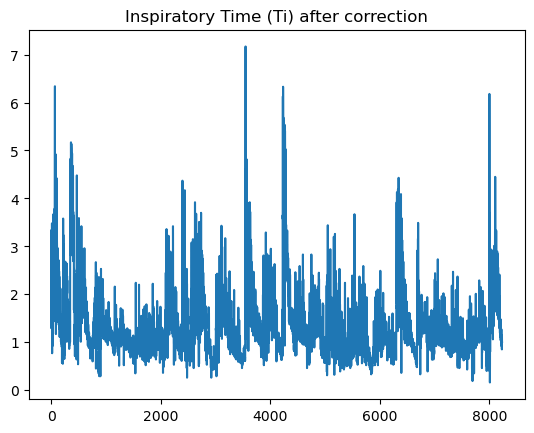

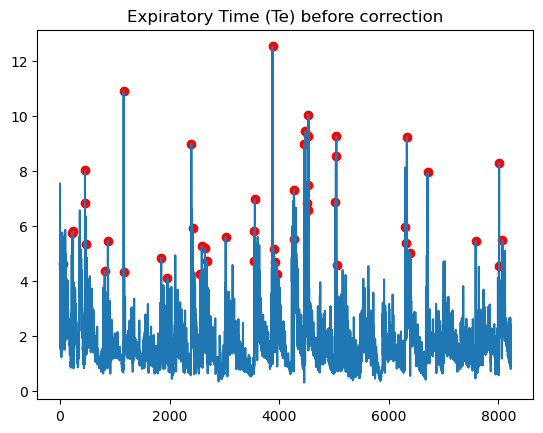

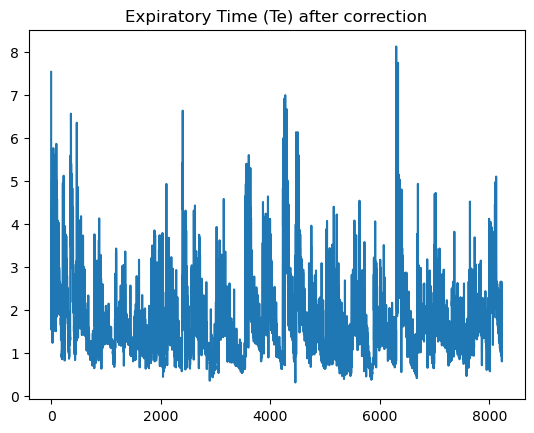

In [29]:
ME_df_edit.reset_index(inplace = True)
ME_df_edit.drop(columns = 'index', inplace = True)

for i in ME_df_edit['Participant'].unique():
    print(ME_df_edit.loc[:2700][(ME_df_edit.loc[:2700]['Participant'] == i) & (ME_df_edit.loc[:2700]['HR'] < 70)]['HR'])
ME_df_edit['HR'].replace(0, np.nan, inplace=True)

# Replace values in 'HR' column that are less than 80 with NaN in the first 2700 rows
ME_df_edit.loc[:2700, 'HR'] = ME_df_edit.loc[:2700, 'HR'].mask(ME_df_edit.loc[:2700, 'HR'] < 80, np.nan)

vevo2_incr = find_large_increments(ME_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, ME_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    ME_df_edit.loc[i, 'VE/VO2'] = ME_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(ME_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')

vevco2_incr = find_large_increments(ME_df_edit['VE/VCO2'], 28)
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, ME_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    ME_df_edit.loc[i, 'VE/VCO2'] = ME_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(ME_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

ti_incr = find_large_increments(ME_df_edit['Ti'], 3)
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.scatter(ti_incr, ME_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    ME_df_edit.loc[i, 'Ti'] = ME_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(ME_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(ME_df_edit['Te'], 3)
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.scatter(te_incr, ME_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    ME_df_edit.loc[i, 'Te'] = ME_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(ME_df_edit['Te'])
plt.title('Expiratory Time (Te) after correction')

Text(0.5, 1.0, 'Expiratory Time (Te) after 2nd correction')

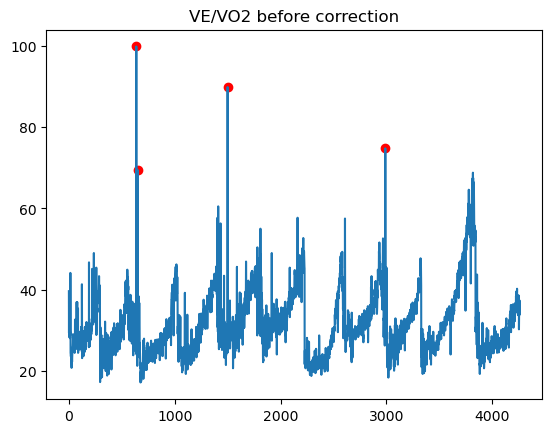

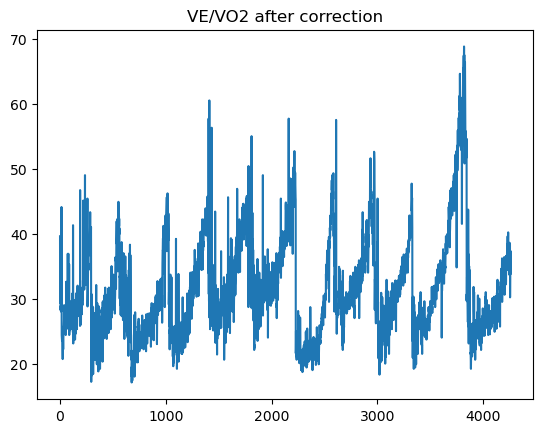

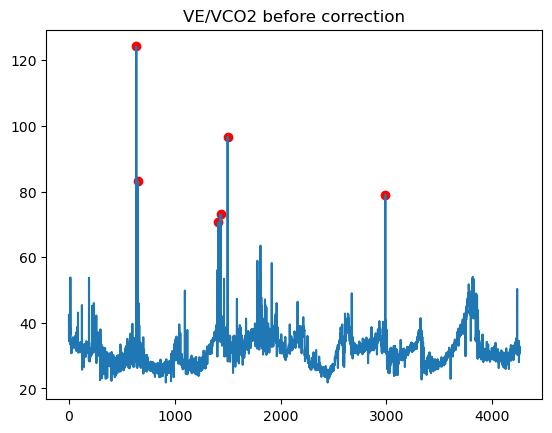

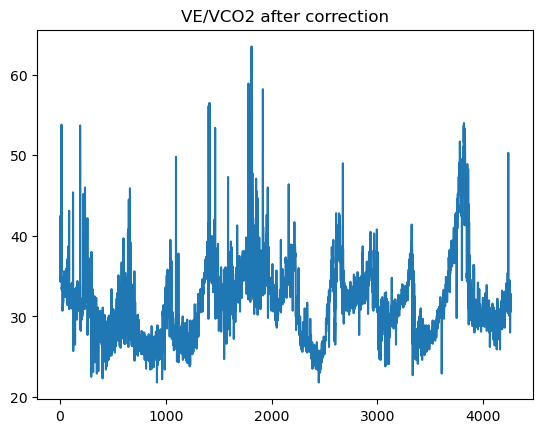

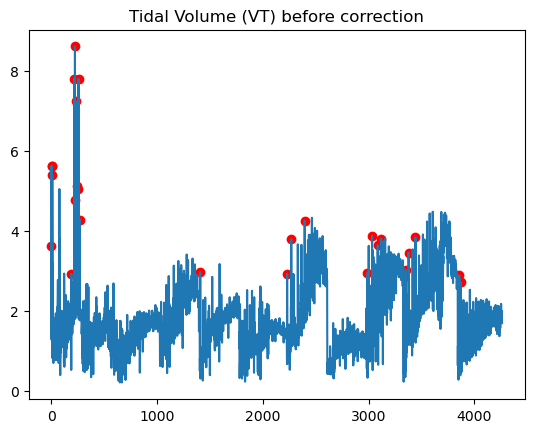

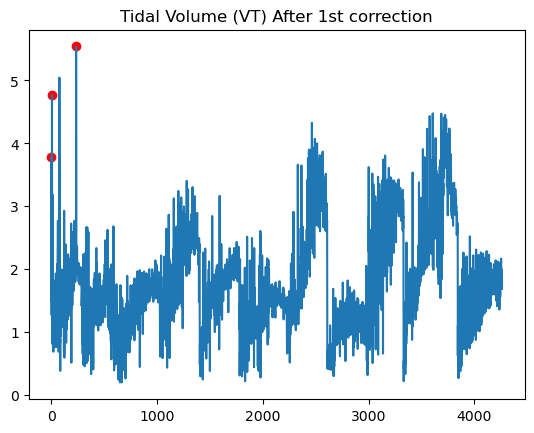

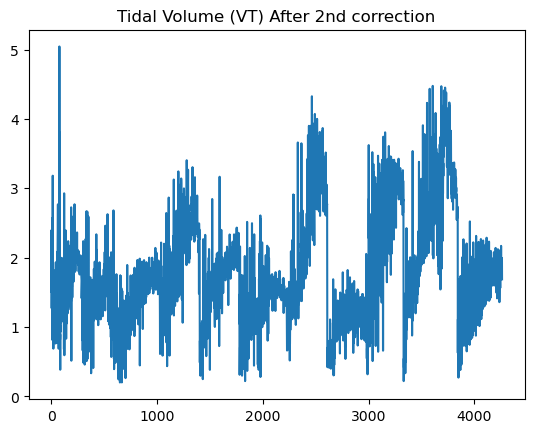

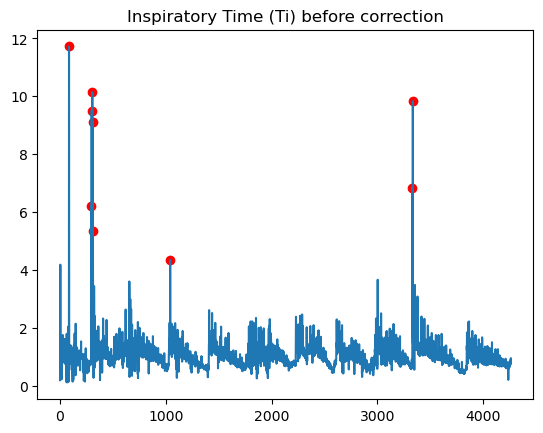

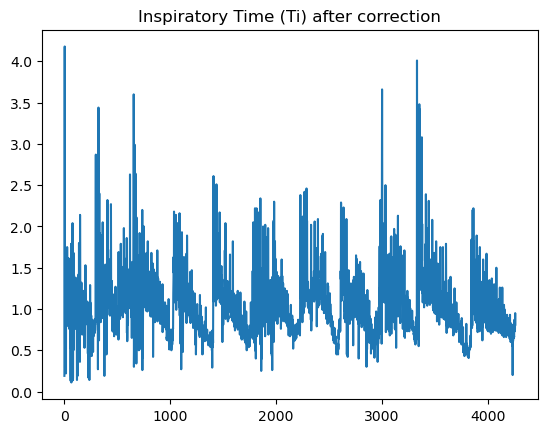

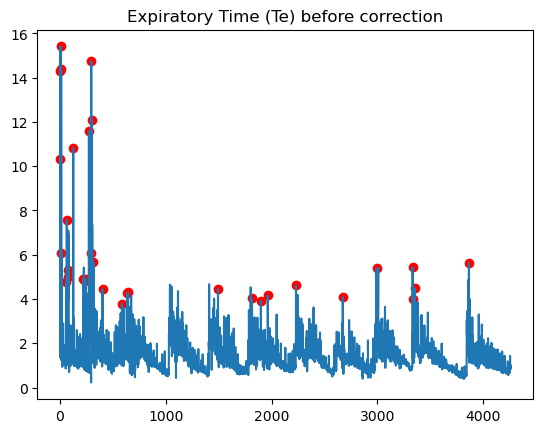

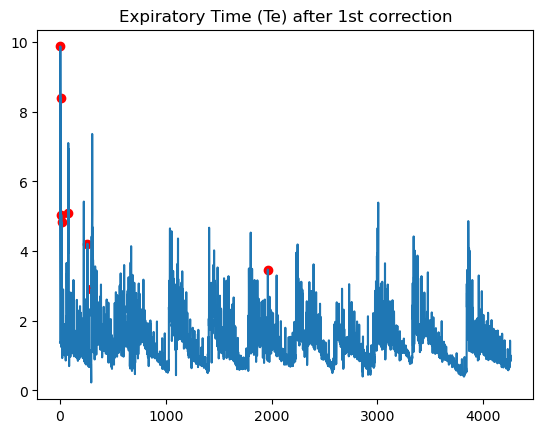

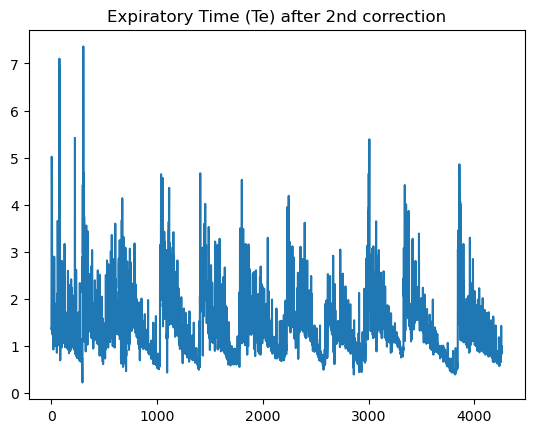

In [30]:
LC_df_edit = copy.deepcopy(LC_df)
LC_df_edit.reset_index(inplace = True)
LC_df_edit.drop(columns = 'index', inplace = True)
LC_df_edit['HR'].replace(0, np.nan, inplace=True)

vevo2_incr = find_large_increments(LC_df_edit['VE/VO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.scatter(vevo2_incr, LC_df_edit['VE/VO2'][vevo2_incr], color = 'red')
plt.title('VE/VO2 before correction')
for i in vevo2_incr:
    LC_df_edit.loc[i, 'VE/VO2'] = LC_df_edit.loc[i-1, 'VE/VO2']
plt.figure()
plt.plot(LC_df_edit['VE/VO2'])
plt.title('VE/VO2 after correction')    

vevco2_incr = find_large_increments(LC_df_edit['VE/VCO2'], 30)
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.scatter(vevco2_incr, LC_df_edit['VE/VCO2'][vevco2_incr], color = 'red')
plt.title('VE/VCO2 before correction')
for i in vevco2_incr:
    LC_df_edit.loc[i, 'VE/VCO2'] = LC_df_edit.loc[i-1, 'VE/VCO2']
plt.figure()
plt.plot(LC_df_edit['VE/VCO2'])
plt.title('VE/VCO2 after correction')

tv_incr = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incr, LC_df_edit['VT'][tv_incr], color = 'red')
plt.title('Tidal Volume (VT) before correction')
for i in tv_incr:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
tv_incra = find_large_increments(LC_df_edit['VT'], 2)
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.scatter(tv_incra, LC_df_edit['VT'][tv_incra], color = 'red')
plt.title('Tidal Volume (VT) After 1st correction')
for i in tv_incra:
    LC_df_edit.loc[i, 'VT'] = LC_df_edit.loc[i-1, 'VT']
plt.figure()
plt.plot(LC_df_edit['VT'])
plt.title('Tidal Volume (VT) After 2nd correction')


ti_incr = find_large_increments(LC_df_edit['Ti'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.scatter(ti_incr, LC_df_edit['Ti'][ti_incr], color = 'red')
plt.title('Inspiratory Time (Ti) before correction')
for i in ti_incr:
    LC_df_edit.loc[i, 'Ti'] = LC_df_edit.loc[i-1, 'Ti']
plt.figure()
plt.plot(LC_df_edit['Ti'])
plt.title('Inspiratory Time (Ti) after correction')

te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) before correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
te_incr = find_large_increments(LC_df_edit['Te'], 2.5)
plt.plot(LC_df_edit['Te'])
plt.scatter(te_incr, LC_df_edit['Te'][te_incr], color = 'red')
plt.title('Expiratory Time (Te) after 1st correction')
for i in te_incr:
    LC_df_edit.loc[i, 'Te'] = LC_df_edit.loc[i-1, 'Te']
plt.figure()
plt.plot(LC_df_edit['Te'])
plt.title('Expiratory Time (Te) after 2nd correction')


#### Removing participant 6 for being a huge outlier (TEMPORARY DECISION) (Currently disabled)

In [36]:
idxdx = LC_df_edit['Participant'] == 'LC_6'
LC_df_edit = LC_df_edit.loc[-idxdx]


### Exporting the data

In [38]:
for df in [Control_df_edit, LC_df_edit, ME_df_edit]:
    df.fillna('NAN', inplace = True)

In [39]:
for group_name, df_group in zip(['Controls', 'LC', 'ME'], [Control_df_edit, LC_df_edit, ME_df_edit]):     
    df_group.to_csv(f'{group_name}.data', sep=',', index = False)

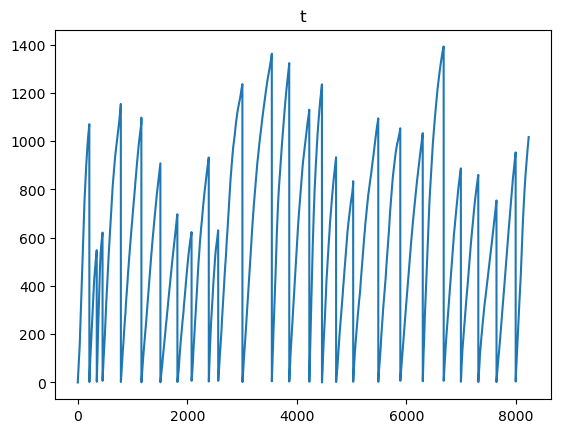

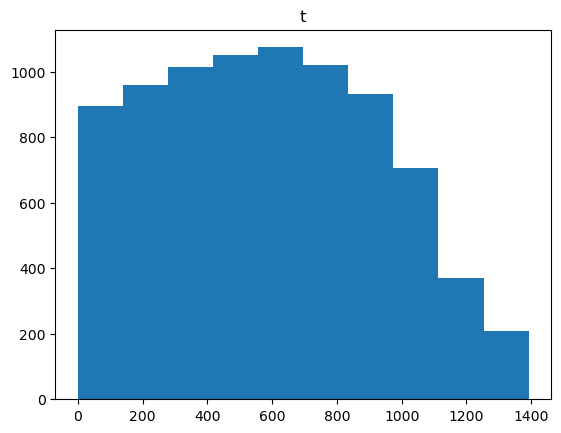

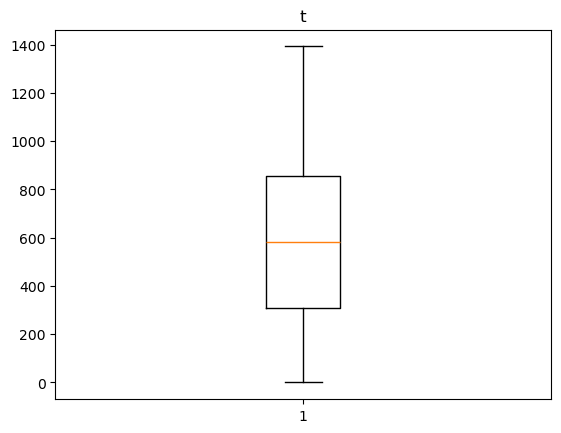

count    8232.000000
mean      590.852405
std       342.108855
min         0.000000
25%       307.750000
50%       580.000000
75%       856.000000
max      1392.000000
Name: t, dtype: float64
0


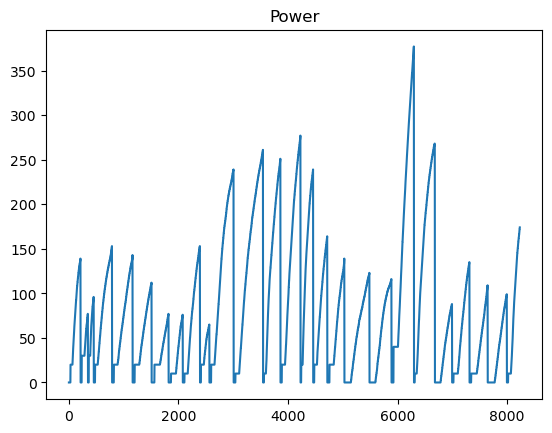

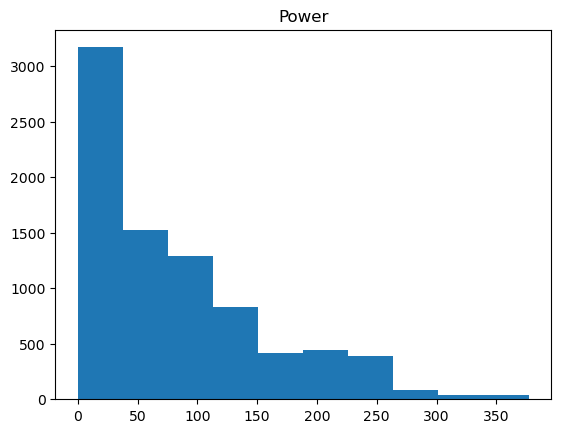

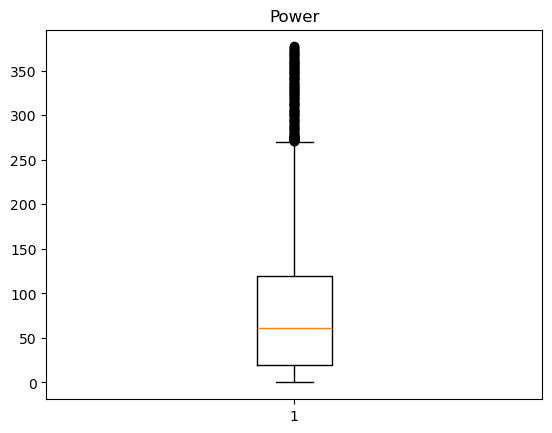

count    8232.000000
mean       80.445700
std        76.317939
min         0.000000
25%        20.000000
50%        61.000000
75%       120.000000
max       377.000000
Name: Power, dtype: float64
0


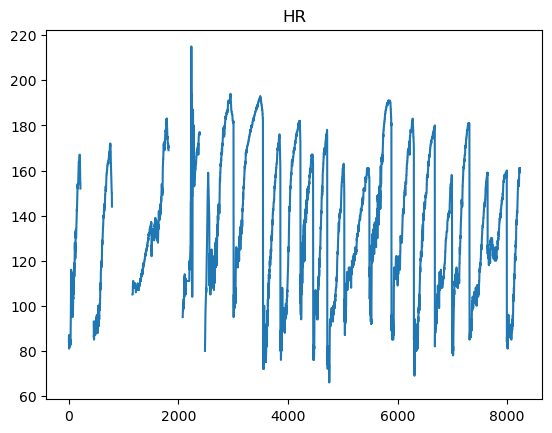

TypeError: '<=' not supported between instances of 'float' and 'str'

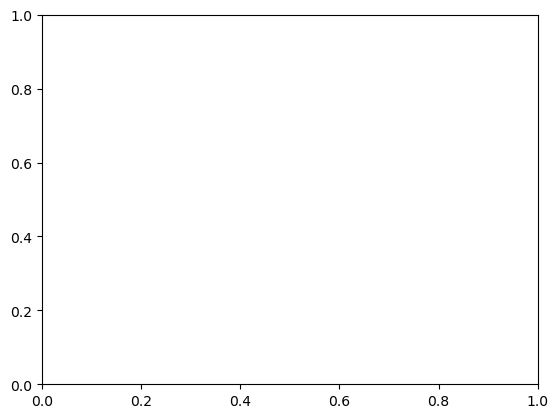

In [35]:
import matplotlib.pyplot as plt
def explory(dataframe, column):
    plt.figure(1)
    plt.plot(dataframe[column])
    plt.title(column)
    plt.show()
    plt.figure(2)
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()
    plt.figure(3)
    plt.boxplot(dataframe[column])
    plt.title(column)
    plt.show()
    print(dataframe[column].describe())
    print(dataframe[column].isna().sum())
df = ME_df_edit
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)
for column in df.columns:
    explory(df, column)